# Statistical Rethinking Week 1 Homework

In [1]:
using Distributions
using StatsBase
using Plots
using StatsPlots

1. Suppose the globe tossing data had turned out to be 8 water in 15 tosses.
Construct the posterior distribution, using grid approximation. Use the
same flat prior as before.


1. Create grid of p from 0 to 1 with 1000 values 
2. Create uniform prior
3. $P(p|W,N)=\frac{P(W,N|p) \times P(p)}{\sum^{p} P(W|N,p) \times P(p)}$
$p$
4. Compute $P(W|N,p)$ as a model such that $W ~ Binomial(N,p)$

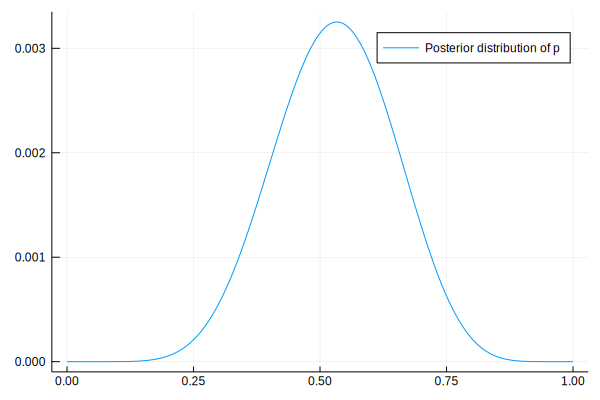

In [2]:
# create grid for p, initialising 1000 values
p_grid = range(0.0, stop=1.0, length=1000)
# create uniform prior for p
p_prior = ones(length(p_grid))
# compute the likelihood, or probability of the data
likelihood_dist = pdf.(Distributions.Binomial.(15, p_grid), 8)
# compute posterior and normalised posterior
posterior = likelihood_dist .* p_prior
normalised_posterior = posterior ./ sum(posterior)

plot(p_grid,normalised_posterior, label="Posterior distribution of p")

2. Start over in 1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5. This corresponds to prior information that a majority
of the Earth’s surface is water. What difference does the better prior make?
If it helps, compare posterior distributions (using both priors) to the true
value p = 0.7.


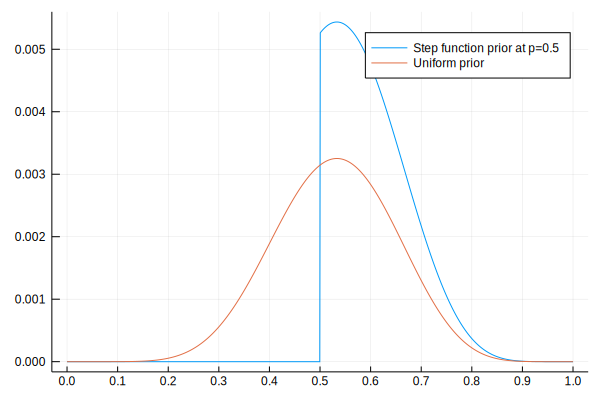

In [3]:
# new prior, where we use prior information that majority of Earth's surface is water
p_prior_majority = [x>0.5 ? 2 : 0 for x in p_grid]
# compute probability of data according to the model
likelihood_majority = @.pdf(Distributions.Binomial(15, p_grid), 8)
# compute posteriors
posterior_maj = likelihood_majority .* p_prior_majority
normalised_post_maj = posterior_maj ./ sum(posterior_maj)
# remember here that labels requrires a 2D matrix - use spaces to separate columns of labels
plot(p_grid, [normalised_post_maj normalised_posterior], 
    labels=["Step function prior at p=0.5" "Uniform prior"],
    xticks = 0.0:0.1:1.0)

Maximum a posteriori appears to be in similar position (~$p=0.55$). However, probability of $p<0.5$ is now zero. The step prior appears to nullify the likelihood of certain values of $p$ and increase the relative likelihood of values of $p$ near the maximum of the uniform posterior. That is, the step function posterior is almost an elongated version of the uniform prior

Given that, however, increased plausibility of values near the true value. Informative prior here helps due to lack of data

3. This problem is more open-ended than the others. Feel free to collaborate on the solution. Suppose you want to estimate the Earth’s proportion of
water very precisely. Specifically, you want the 99% percentile interval of the
posterior distribution of p to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many
times will you have to toss the globe to do this? I won’t require a precise
answer. I’m honestly more interested in your approach.


1. Use the true value of p

In [4]:
p_true = 0.7

0.7

2. Initialise the prior and grid for p for grid approximation

In [5]:
p_grid = range(0.0, stop=1.0, length=1000)
uniform_prior = ones(length(p_grid));

3. Create a series of functions that:
 * Using the true value of p and the number of tosses, generates sample observed data
 * Using prior and grid approximation, calculates likelihood of observed data and then samples from it
 * Calculates the quantiles required for the PIs and then the width of the PI

In [57]:
"""
Creates observed data (# of successes) based on the true proportion of water on the Earth, p_true
"""
function observed_data(tosses::Int64, p_true::Float64)

    dist = Distributions.Binomial(tosses, p_true)
    return rand(dist)
end

"""
Calculates the likelihood of the data using a data point (# of successes) and a parameter grid p_grid
"""
function calculate_likelihood(tosses::Int64, data::Int64, p_grid)

    dists = Distributions.Binomial.(tosses, p_grid)
    likelihood = pdf.(dists, data)
    return likelihood
end

"""
Posterior distribution calculation that returns posterior probabilities and associated grid
"""    
function calculate_posterior(grid, prior, likelihood)
    @assert length(prior) == length(likelihood)
    posterior = prior .* likelihood
    std_posterior = posterior ./ sum(posterior)
    return std_posterior
end

"""
Returns 10,000 samples from the posterior distribution
"""
function sampling_posterior(grid, std_posterior)

    return sample(Array(grid), Weights(std_posterior), 10000, replace=true)
end

"""
For a given percentile interval (PI), calculates the width of the PI
"""
function percentile_interval_width(interval::Float64, samples)

    omitted_mass = 1 - interval
    lower_interval, upper_interval = omitted_mass/2, 1-(omitted_mass/2)
    quantiles = StatsBase.quantile(samples, [lower_interval, upper_interval])
    width = quantiles[2] - quantiles[1]
    return width
end;

4. Loop across the number of globe tosses to see how the number of tosses affects PI width

In [99]:
function PI99_width(tosses::Int64, p_true::Float64, grid::AbstractRange, prior::AbstractArray)
    data = observed_data(tosses, p_true)
    posterior = calculate_posterior(grid, prior, calculate_likelihood(tosses, data, grid))
    samples = sampling_posterior(grid, posterior)
    return percentile_interval_width(0.99, samples)
end

toss_range = range(1, step=10, length=1000)
pi_widths = []
for n in toss_range
    push!(pi_widths, PI99_width(n, p_true, p_grid, uniform_prior)) 
end

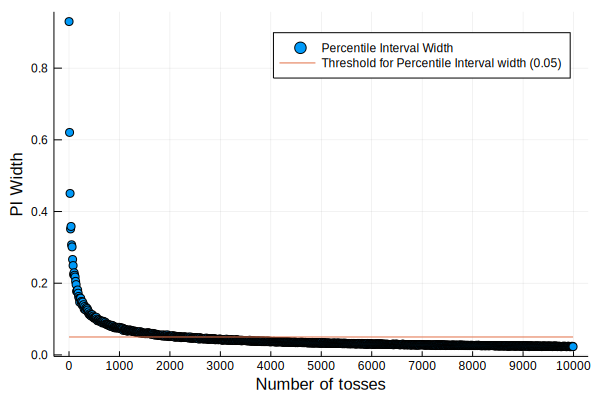

In [104]:
scatter(toss_range, pi_widths, labels="Percentile Interval Width")
xlabel!("Number of tosses")
ylabel!("PI Width")
xticks!(0:1000:10000)
plot!(toss_range, fill(0.05, length(toss_range)), labels="Threshold for Percentile Interval width (0.05)")

We need to toss the globe approximately 2000 times before the 99% percentile interval for the proportion of water $p$ is only 0.05 wide